<a target="_blank" href="https://colab.research.google.com/github/Jayku88/BSF_Training_IIST_2026/blob/main/BSF_Training_Notebook_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Computational Complexity of systems

In [ ]:
import time
start_time=time.time()
for i in range(0,2**29):
  continue
end_time=time.time()
print(end_time-start_time)

## Problem Solving Methodologies


1.   Brute Force (Try everything)
2.   Divide and Conquer (Break the problem into independent subproblems, solve them, then combine)

1.   Dynamic Programming (Divide and conquer plus memory)
2.   Approximation (Get a good enough solution when exact is too expensive)





## Installing Required Libraries

In [ ]:
# Install geospatial libraries
!pip install rioxarray

# Install visualization library
!pip install matplotlib

# Intall array process library
!pip install numpy

## Importing Required Libraries

In [ ]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Download image from following link and upload to files in Colab
https://drive.google.com/file/d/1dNWpf8lEOiSdQoyS2GcteZihmlIV3HQI/view?usp=sharing


## Reading the Raster File

In [ ]:
img = rioxarray.open_rasterio("ambazac_3.tif")

## Create RGB visualization

In [ ]:
img.sel(band=[3, 2, 1]).plot.imshow(robust=True, figsize=(10, 8))
plt.title("True Color RGB Composite - Ambazac Region")
plt.show()

In [ ]:
# Display image information
print("=" * 60)
print("IMAGE PROPERTIES")
print("=" * 60)
print(f"\nShape (bands, height, width): {img.shape}")
print(f"Number of bands: {img.sizes['band']}")
print(f"Spatial dimensions: {img.sizes['y']} x {img.sizes['x']} pixels")
print(f"\nCoordinate Reference System (CRS): {img.rio.crs}")
print(f"Data type: {img.dtype}")
print("\nBands available:", img.attrs['long_name'])

## Sentinel-2 Band Clues
B02 → Blue

B03 → Green

B04 → Red

B08 → Near Infrared (NIR)

B8A → Narrow NIR

B11 → Shortwave Infrared (SWIR 1)

B12 → Shortwave Infrared (SWIR 2)

SCL → Scene Classification Layer (clouds, vegetation, water, etc.)

In [ ]:
# Extract individual bands
swir1 = img.sel(band=6)
swir2 = img.sel(band=7)
red = img.sel(band=3)
green = img.sel(band=2)
blue = img.sel(band=1)
nir = img.sel(band=4)

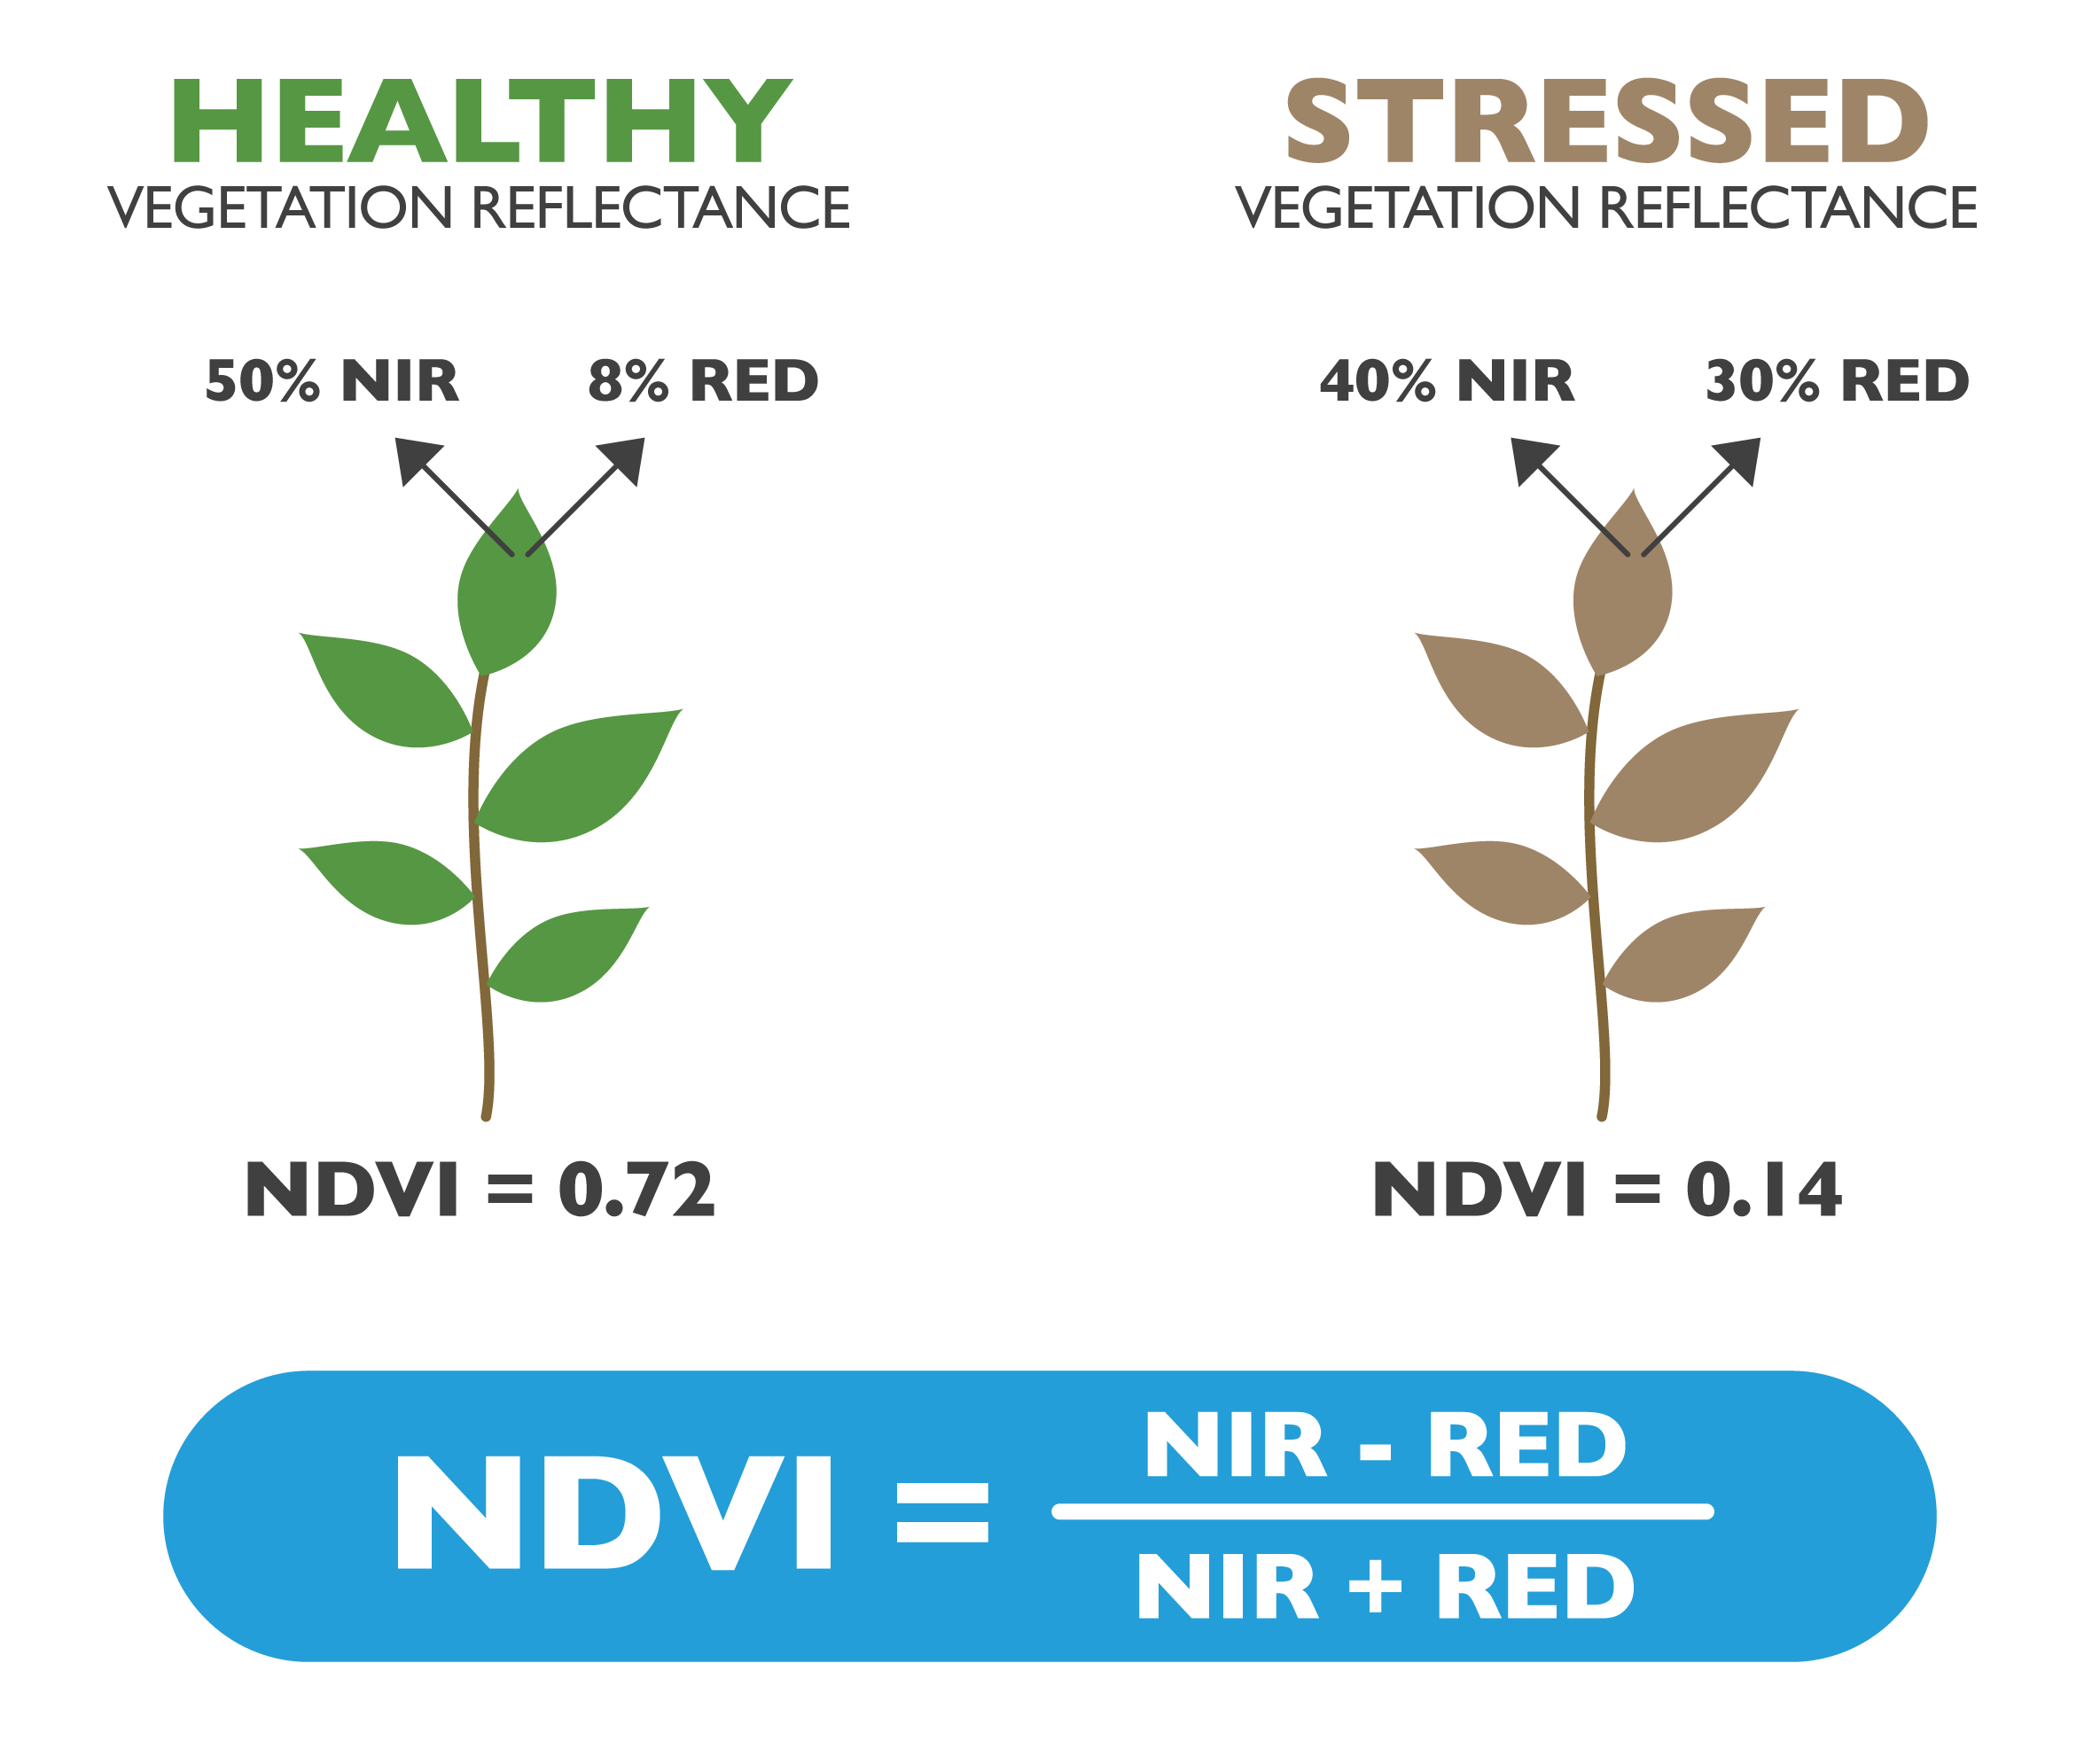

In [ ]:
ndvi = (nir - red) / (nir + red)

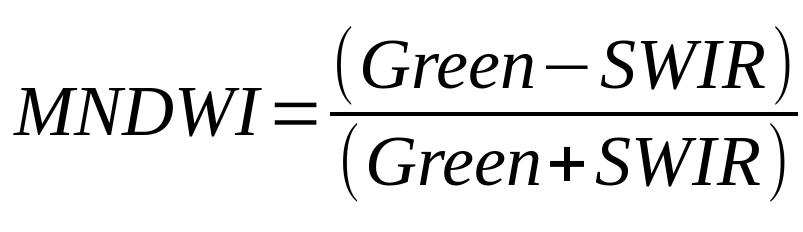

In [ ]:
mndwi = (green - swir1) / (green + swir1)

## Deterministic Approach

In [ ]:
colors = ["blue","lightgreen","green","brown"]
cmap = ListedColormap(colors)

water = mndwi > 0
field = (ndvi > 0.3) & (ndvi <0.65)
forest = ndvi>=0.65
bare_soil_mask =  (0 > mndwi) & (ndvi < 0.3)

classified_element = np.select([water,field, forest,bare_soil_mask],[0,1,2,3],default=np.nan)
fig, axes = plt.subplots(1,2,figsize=(15,6))
im = axes[0].imshow(classified_element,cmap=cmap,
                      extent=[img.x.min(), img.x.max(),
                             img.y.min(), img.y.max()])


img.sel(band=[3,2,1]).plot.imshow(ax=axes[1],robust=True)
cbar = plt.colorbar(im,ax=axes[0], ticks=[0,1,2,3])
cbar.set_ticklabels([ 'Water', 'field','forest', 'Bare soil'])
axes[0].set_title("Multi-Index Classification")
axes[1].set_title("Image RGB")

plt.tight_layout()
plt.show()

## Calculate area statistics

In [ ]:
pixel_size = 10 * 10  # Sentinel-2: 10m x 10m = 100 m² per pixel
total_pixels = classified_element.size
total_area_km2 = (total_pixels * pixel_size) / 1_000_000

# Count pixels for each class
water_count = (classified_element == 0).sum()
field_count = (classified_element == 1).sum()
forest_count = (classified_element == 2).sum()
bare_soil_count = (classified_element == 3).sum()

# Display results
print("=" * 50)
print("  LAND COVER CLASSIFICATION RESULTS")
print("=" * 50)
print(f"\nTotal study area: {total_area_km2:.2f} km²")
print(f"Total pixels: {total_pixels:,}")
print(f"\nClass Distribution:")
print("-" * 50)

classes = [
    ("Water", water_count),
    ("Agricultural Fields", field_count),
    ("Forest", forest_count),
    ("Bare Soil/Urban", bare_soil_count)
]

for class_name, count in classes:
    percentage = (count / total_pixels) * 100
    area_km2 = (count * pixel_size) / 1_000_000
    print(f"{class_name:20s}: {count:>10,} pixels ({percentage:>5.1f}%) - {area_km2:>7.2f} km²")

print("=" * 50)
print(f"\nTotal classified area: {total_area_km2:.2f} km²")
print(f"   Total pixels: {total_pixels:,}")

## Machine Learning Approach

In [ ]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open("ambazac_3.tif") as src:
    img = src.read()   # shape: (bands, height, width)

print(img.shape)


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# reshape image to pixels x bands
X = img.reshape(img.shape[0], -1).T

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

clustered = labels.reshape(img.shape[1], img.shape[2])

plt.imshow(clustered, cmap="tab10")
plt.title("K-Means Land Cover Clustering")
plt.axis("off")
